In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import AutoTokenizer, BertForMaskedLM
from torch.nn.functional import softmax
import torch
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher
from spellchecker import SpellChecker
from string import punctuation
import nltk
import time
nltk.download('words')
tokenizer =   AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model     = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

[nltk_data] Downloading package words to C:\Users\bills-fish-
[nltk_data]     shack\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [2]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
wl    = set(nltk.corpus.words.words())
in_wl = np.vectorize(lambda x: x in wl)
lin_map = np.vectorize(lambda x: 2*x - 1)  # allow to be applied along vectors
log_map = lambda e: np.vectorize(lambda x: np.power(np.log(x/0.5)/np.log(2), e))  # specify exponent to return vectorized mapping
arrLower   = np.vectorize(lambda x: x.lower())
spelling   = SpellChecker()


In [3]:
string = "The capital of France is (Paris)."
n      = 1  # 1 is last word
words  = string.split()
masked = "[MASK]" + words[-n][-1] if not words[-n][-1].isalpha() else "[MASK]"
target = words[-n].strip(punctuation)
prompt = ' '.join(words[:-n] + [masked] + words[len(words)-(n-1):])
prompt, target

('The capital of France is [MASK].', 'Paris')

In [4]:
t0=time.time()
inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

mask_index  = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
mask_logits = logits.squeeze()[mask_index].squeeze()
probs = softmax(mask_logits, dim=-1)
topk = 10
topk_probs, topk_i = torch.topk(probs, topk, dim=-1)
topk_tokens = np.array([tokenizer.decode([i]) for i in topk_i])
np.hstack((topk_tokens.reshape(-1,1), np.array(topk_probs).reshape(-1,1)))
t1=time.time()
t1-t0

0.32225775718688965

In [5]:
#  "I rally regret", "when you come over can you being", "can you really climb all the way up that birdling"
strings = ["when you come over can you being"]
back_n  = 3  # number of words back from end of string, 1 is just last word
places = [range(1,back_n+1)] * len(strings)  # 1 is last word
data = []
for string, places in zip(strings, places):
    case = []
    for n in places:
        words  = string.split()
        if n > len(words): break
        masked = "[MASK]" + words[-n][-1] if not words[-n][-1].isalpha() else "[MASK]"
        target = words[-n].strip(punctuation)
        prompt = ' '.join(words[:-n] + [masked] + words[len(words)-(n-1):])
        
        inputs = tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
            logits = model(**inputs).logits
        mask_index  = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        mask_logits = logits.squeeze()[mask_index].squeeze()
        probs = softmax(mask_logits, dim=-1)
        topk = 5000
        topk_probs, topk_i = torch.topk(probs, topk, dim=-1)
        topk_tokens = np.array([tokenizer.decode([i]) for i in topk_i])
        probs = np.hstack((topk_tokens.reshape(-1,1), np.array(topk_probs).reshape(-1,1)))
        
        probsp = [(word, float(prob), float(similar(target, word))) for word, prob in probs if word in wl]
        close_probs = [prob for prob in probsp if prob[2] > 0.5 and prob[1] >= min(0.001, probsp[200][1])]
        close_adj = pd.DataFrame([(word, sim, lin_map(sim), log_map(np.e)(sim), prob, 
                                   prob*lin_map(sim), prob*log_map(np.e)(sim), (prob*log_map(np.e)(sim))/(prob+log_map(np.e)(sim))) for word, prob, sim in close_probs],
                                 columns=["word", "similarity", "lin-map sim", "log-map sim", 
                                          "probability", "lin-map prob", "log-map prob", "swag"])
        close_adj["log-map sim"] = close_adj["log-map sim"].apply(pd.to_numeric)
        close_adj["lin-map sim"] = close_adj["lin-map sim"].apply(pd.to_numeric)
        props = close_adj[["word", "similarity", "log-map prob"]].sort_values("log-map prob", ascending=False)
        case.append([(prompt, target), probsp, props])
    data.append(case)

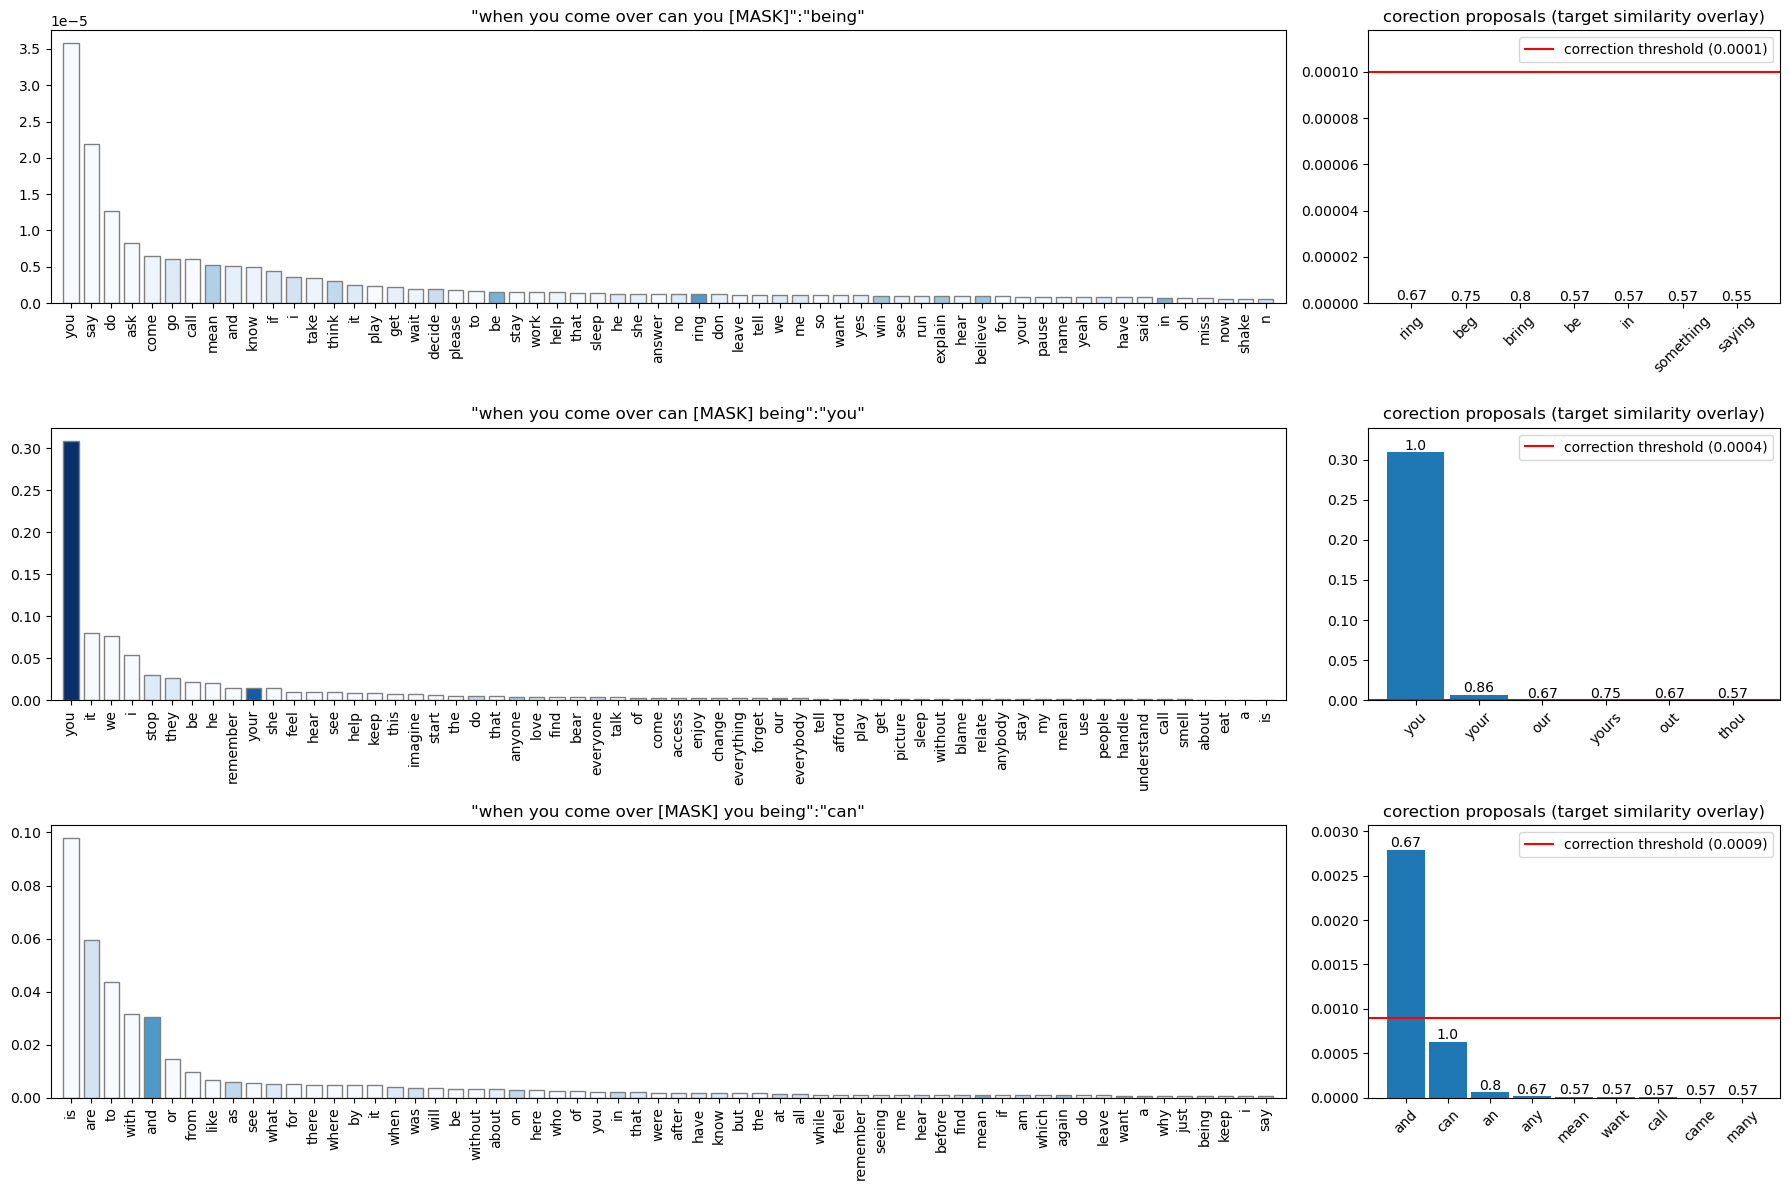

In [6]:
for case in data:
    fig, (axes) = plt.subplots(len(case), 2, figsize=(18,4*len(case)), width_ratios=(3,1))
    n = 1
    for ((prompt, target), probsp, props), (ax) in zip(case, axes.reshape(-1, 2)):
        ax1, ax2 = ax[0], ax[1]
        topN = 60
        probs_plot = np.array(probsp[:topN])
        cmap = mpl.colormaps['Blues']
        norm = mpl.colors.Normalize(vmin=0.18, vmax=1.0)
        ax1.bar(probs_plot[:,0], probs_plot[:,1].astype(float), width=0.75, edgecolor='gray',
                color=cmap(norm(probs_plot[:,2].astype(float))))
        ax1.set_xlim(-1,topN)
        ax1.set_xticks(range(len(probs_plot[:,0])), probs_plot[:,0], rotation=90, fontsize=10)
        ax1.set_title(f'"{prompt if len(prompt) < 130 else f"...{prompt[-130:]}"}":"{target}"')
        
        probN = 0.0001 * (n**2)
        propsp = props[["word", "log-map prob"]].values[:10]
        if len(propsp) == 0:
            propsp = np.array([['', 0]])
        for bar, sim in zip(ax2.bar(propsp[:,0], propsp[:,1], width=.9), 
                            props["similarity"].values):
            height = bar.get_height()
            ax2.text(bar.get_x()+0.45, bar.get_height()+(max(propsp[0,1], probN)*0.01), round(sim, 2), horizontalalignment='center')
        ax2.set_xticks(range(len(propsp[:,0])), propsp[:,0], rotation=45)
        ax2.set_ylim([0, max(float(propsp[0,1])*1.1, probN*1.18)])
        ax2.axhline(y=probN, color='r', label=f'correction threshold ({probN:.4f})')
        ax2.set_title('corection proposals (target similarity overlay)')
        ax2.legend(loc="upper right")
        n += 1
    plt.tight_layout()
    plt.show()